In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import Normalizer
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import statistics
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing


In [ ]:
!pip3 install uci-dataset
from sklearn import datasets
import uci_dataset as dataset
!git clone https://github.com/tanmay-pro/sampleData.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'sampleData' already exists and is not an empty directory.


In [ ]:
#1 Normal KNN
def normalKNN(trainX, testX, trainY, testY):
  bestAcc = 0
  bestK = 0
  for k in range (2, 10): 
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')
    model.fit(trainX, trainY)
    predicted = model.predict(testX)
    accuracyScore = metrics.accuracy_score(testY, predicted)
    if accuracyScore > bestAcc:
      bestK = k
      bestAcc = accuracyScore

  model = KNeighborsClassifier(n_neighbors= bestK, algorithm='ball_tree')
  model.fit(trainX, trainY)
  predicted = model.predict(testX)
  return predicted, bestAcc, bestK

Leave-one-out cross validation is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set. That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point

In [ ]:
#2 unristricted
def getValidk(trainX):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  validK = []
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    validSampleK = []
    for k in range(2, 10):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:   
            validSampleK.append(k)
    validK.append(validSampleK)
  validK = np.array(validK, dtype=object)
  return validK

def getPreTrainedModels(trainX, trainY):
  trainedModels = []
  for i in range(2, 10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(trainX, trainY)
    trainedModels.append(model)
  return trainedModels    

def getPrediction(validK, trainedModels, M, trainX, testX, trainY):
  unique_k =set()
  finalPredictions = []
  predictedKFrequency = [0]*10
  for i in range(0, len(testX)):
    distances = []
    for j in range(0, len(trainX)):
        distances.append(np.linalg.norm(testX[i] - trainX[j]))
    distances = np.array(distances)
    indices = np.argsort(distances)
    nebrIndices = indices[0:M]
    nebrLabels = trainY[nebrIndices]

    kCorrectClassified = np.zeros(10)
    for ind in nebrIndices:
        kcurrArray = validK[ind]
        for z in range(len(kcurrArray)):
            k = kcurrArray[z]
            kCorrectClassified[k] += 1
    kbest = np.argmax(kCorrectClassified)
    unique_k.add(kbest)
    predictedKFrequency[kbest] += 1
    predictedClass = trainedModels[kbest - 2].predict(testX[i].reshape(1, -1))
    finalPredictions.append(predictedClass)
  return finalPredictions, predictedKFrequency, unique_k 

def localUnrestrictedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX)
  trainedModels = getPreTrainedModels(trainX, trainY)
  predicted, predictedKFrequency,unique_k = getPrediction(validK, trainedModels, M, trainX, testX, trainY)
  return predicted, predictedKFrequency, metrics.accuracy_score(testY, predicted),statistics.mean(unique_k) 

In [ ]:
#3 prunned
def prunedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX)
  finalK = []
  for lst in validK:
    finalK = finalK + lst
  freq = np.bincount(np.array(finalK))

  bestL = 0
  bestScore = -1
  accValuesL = []
  for L in range(2, np.max(freq),100):
    array_list = []
    for m in range(len(validK)):
      array_list.append(np.array(validK[m]))

    validK = array_list
    arr = np.array(validK, dtype=object)
    freq_to_prune = []
    
    for i in range(len(freq)):
      if(freq[i] < L):
        freq_to_prune.append(i)

    for i in range(arr.shape[0]):
      for j in freq_to_prune:
        if j in arr[i] and arr[i].shape[0] != 1:
          arr[i] = np.delete(arr[i], np.where(arr[i] == j))

    validK = []
    for i in range(arr.shape[0]):
      validK.append(arr[i])
    trainedModels = getPreTrainedModels(trainX, trainY)
    predicted, predictedKFrequency,unique_k = getPrediction(validK, trainedModels, M, trainX, testX, trainY)
   # print(testY.shape, predicted.shape)
    score = metrics.accuracy_score(testY, predicted)
    if(score > bestScore):
      bestScore = score
      bestL = L
    # print("Current Accuracy: ", score, " for:", L)
    accValuesL.append(score)
  print("Best Accuracy: ", bestScore, " for:", bestL)
  plt.plot(accValuesL)
  plt.xlabel("Pruning Threshold")
  plt.ylabel("Accuracy")
  plt.show()
  return predicted, predictedKFrequency, bestScore,statistics.mean(unique_k) 

In [ ]:
#one per class
def k_one_per_class(trainX,trainY):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  unique_class = np.unique(trainY)
  k_for_each_class = {}
  for i in unique_class:
    k_for_each_class[i] = [0 for i in range(2,10)]
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    for k in range(2, 10):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:
          k_for_each_class[testLabel[0]][k-2] += 1
        
  k_assigned_for_each_class = {}
  for i in unique_class:
    k_assigned_for_each_class[i] = np.argmax(k_for_each_class[i])+2
  return k_assigned_for_each_class

def localKNNoneperclass(trainX, testX, trainY, testY):
  unique_k = set()
  k_assigned_for_each_class = k_one_per_class(trainX,trainY)
  predicted = []
  predictedKFrequency = [0]*10
  for key in k_assigned_for_each_class:
    predictedKFrequency[k_assigned_for_each_class[key]] += 1
  for i in range(0, len(testX)):
    distances = []
    for j in range(0, len(trainX)):
        distances.append(np.linalg.norm(testX[i] - trainX[j]))
    distances = np.array(distances)
    indices = np.argsort(distances)
    percent_of_classification_as_class = {}
    for x in k_assigned_for_each_class:
      k = k_assigned_for_each_class[x]
      unique_k.add(k)
      nebrIndices = indices[0:k]
      nebrLabels = trainY[nebrIndices]
      percent_of_classification_as_class[x] = np.count_nonzero(nebrLabels == x)/k
    predicted.append(max(percent_of_classification_as_class, key=percent_of_classification_as_class.get))
  return predicted, metrics.accuracy_score(testY, predicted), predictedKFrequency,statistics.mean(unique_k) 

In [ ]:
#one per cluster
def getK(trainX):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(2,50), timings=False)
  visualizer.fit(trainX)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure
  kAtElbow = visualizer.elbow_value_
  return kAtElbow

def getValidk(trainX):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  validK = []
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    validSampleK = []
    for k in range(2, 10):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:   
            validSampleK.append(k)
    validK.append(validSampleK)
  validK = np.array(validK, dtype=object)
  return validK

def getPreTrainedModels(trainX, trainY):
  trainedModels = []
  for i in range(2, 10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(trainX, trainY)
    trainedModels.append(model)
  return trainedModels    

def k_one_per_cluster(trainX, trainY, testX, testY):
    bestK = getK(trainX)
    kmeans = KMeans(n_clusters=bestK, random_state=0).fit(trainX)
    labels = kmeans.labels_
    k_for_each_cluster = {}
    for i in np.unique(labels):
      k_for_each_cluster[i] = [0 for i in range(2,10)]
    validK = getValidk(trainX) 
    for i in range(len(validK)):
      for j in range(len(validK[i])):
        k_for_each_cluster[labels[i]][validK[i][j]-2] += 1
    k_assigned_for_each_cluster = {}
    for i in np.unique(labels):
      k_assigned_for_each_cluster[i] = np.argmax(k_for_each_cluster[i])+2
    return k_assigned_for_each_cluster, labels , kmeans

def localKNNonepercluster(trainX,testX, trainY, testY):
  unique_k =set()
  models = getPreTrainedModels(trainX, trainY)
  k_assigned_for_each_cluster, labels ,kmeans = k_one_per_cluster(trainX, trainY, testX, testY)
  predicted = []
  predictedKFrequency = [0]*10
  for key in k_assigned_for_each_cluster:
    predictedKFrequency[k_assigned_for_each_cluster[key]] += 1
  for i in range(0, len(testX)):
    cluster_predicted = kmeans.predict(testX[i].reshape(1, -1))
    bestk = k_assigned_for_each_cluster[cluster_predicted[0]]
    unique_k.add(bestk)
    model = models[bestk-2]
    predicted.append(model.predict(testX[i].reshape(1, -1)))
  return predicted, metrics.accuracy_score(testY, predicted), predictedKFrequency,statistics.mean(unique_k) 

In [ ]:
def runAll(normalized_x_train, normalized_x_test, trainY, testY):
  print("FOR SIMPLE KNN")
  predicted, accuracyScore, bestK = normalKNN(normalized_x_train, normalized_x_test, trainY, testY)
  print("The best K =", bestK, "and the corresponding accuracy is", accuracyScore)
  print("FOR UNRESTRICTED KNN")
  bestM = 0
  bestScore = -1
  for m in range(2,5):
    predicted, predictedKFrequency, accuracyScore,meank  = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, m)
    if(accuracyScore > bestScore):
      bestScore = accuracyScore
      bestM = m
    print("Current Accuracy: ", accuracyScore, " for m =", m)
    print("The corresponding mean k is", meank)

  predicted, predictedKFrequency, accuracyScore ,meank = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
  print("The corresponding mean k is", meank)
  print("Chosen m = ", bestM)
  plt.plot(predictedKFrequency)
  plt.xlabel("Different K Values")
  plt.ylabel("Frequency of each K Value")
  plt.show()
  print("FOR PRUNNED KNN")
  #print("Best Accuracy: ", bestScore, " for m =", bestM)
  predicted, predictedKFrequency, accuracyScore,meank = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
  print("The corresponding mean k is", meank)
  print("Chosen m = ", bestM)
  plt.plot(predictedKFrequency)
  plt.xlabel("Different K Values")
  plt.ylabel("Frequency of each K Value")
  plt.show()
  print("FOR ONE PER CLASS KNN")
  predicted, accuracyScore, predictedKFrequency,meank = localKNNoneperclass(normalized_x_train, normalized_x_test, trainY, testY)
  print("The corresponding accuracy is", accuracyScore)
  print("The corresponding mean k is", meank)
  print("The corresponding mean k is", meank)
  plt.plot(predictedKFrequency)
  plt.xlabel("Different K Values")
  plt.ylabel("Frequency of each K Value")
  plt.show()
  print("FOR ONE PER CLUSTER KNN")
  predicted, accuracyScore, predictedKFrequency,meank = localKNNonepercluster(normalized_x_train, normalized_x_test, trainY, testY)
  print("The corresponding accuracy is", accuracyScore)
  print("The corresponding mean k is", meank)
  plt.plot(predictedKFrequency)
  plt.xlabel("Different K Values")
  plt.ylabel("Frequency of each K Value")
  plt.show()
  print("\n")

FOR SIMPLE KNN
The best K = 5 and the corresponding accuracy is 1.0
FOR UNRESTRICTED KNN
Current Accuracy:  0.9666666666666667  for m = 2
The corresponding mean k is 2
Current Accuracy:  0.9666666666666667  for m = 3
The corresponding mean k is 2
Current Accuracy:  0.9666666666666667  for m = 4
The corresponding mean k is 2
Accuracy Score =  0.9666666666666667
The corresponding mean k is 2
Chosen m =  2


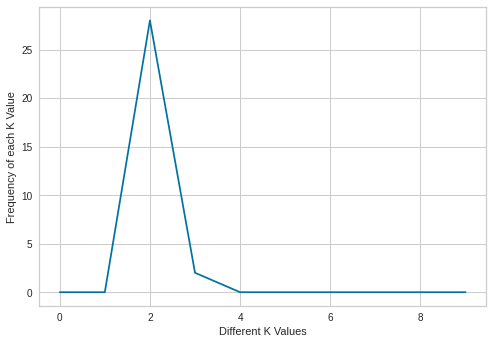

FOR PRUNNED KNN
Best Accuracy:  0.9666666666666667  for: 2


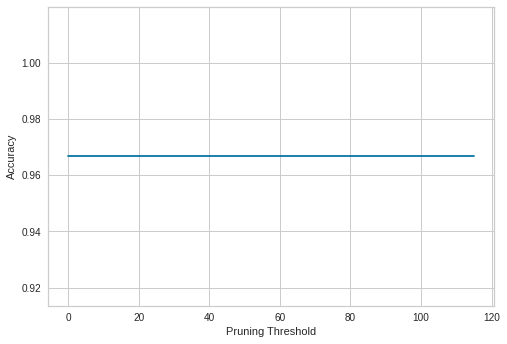

Accuracy Score =  0.9666666666666667
The corresponding mean k is 3
Chosen m =  2


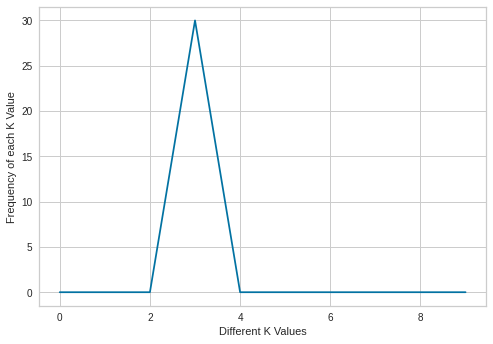

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.9666666666666667
The corresponding mean k is 2
The corresponding mean k is 2


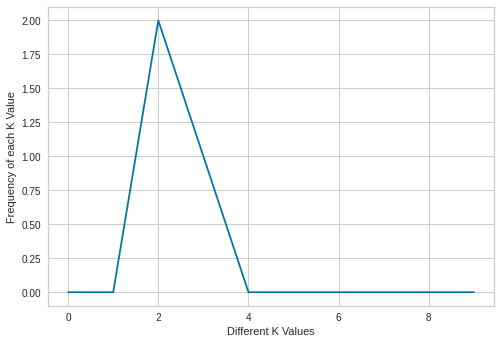

FOR ONE PER CLUSTER KNN


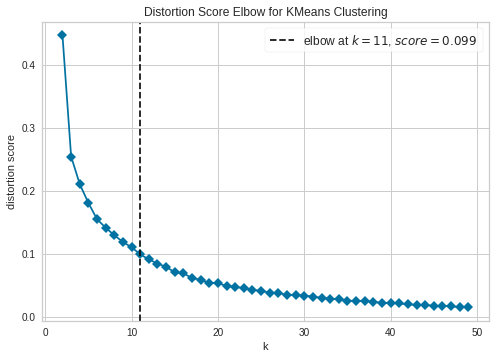

The corresponding accuracy is 0.9666666666666667
The corresponding mean k is 2


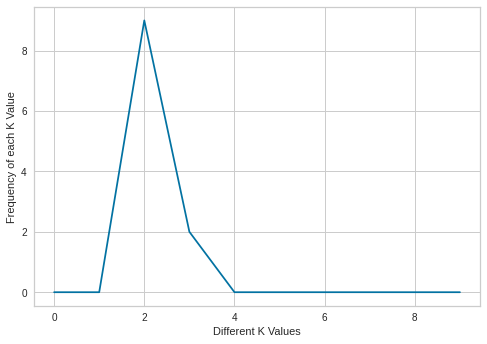



FOR SIMPLE KNN
The best K = 2 and the corresponding accuracy is 0.8611111111111112
FOR UNRESTRICTED KNN
Current Accuracy:  0.8888888888888888  for m = 2
The corresponding mean k is 4
Current Accuracy:  0.8611111111111112  for m = 3
The corresponding mean k is 4
Current Accuracy:  0.8611111111111112  for m = 4
The corresponding mean k is 4
Accuracy Score =  0.8888888888888888
The corresponding mean k is 4
Chosen m =  2


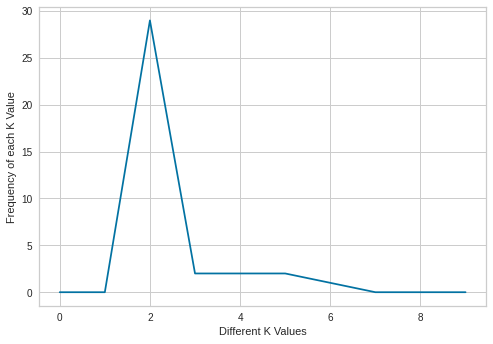

FOR PRUNNED KNN
Best Accuracy:  0.8888888888888888  for: 2


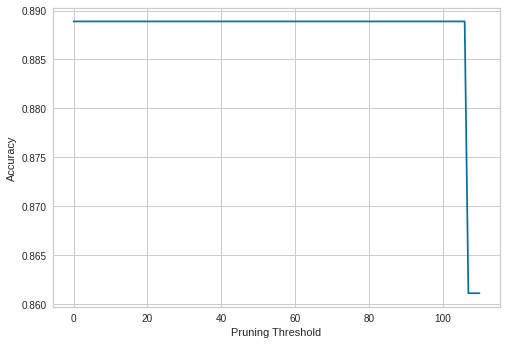

Accuracy Score =  0.8611111111111112
The corresponding mean k is 6
Chosen m =  2


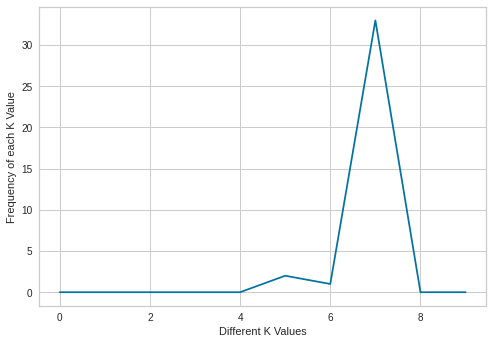

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.8611111111111112
The corresponding mean k is 5
The corresponding mean k is 5


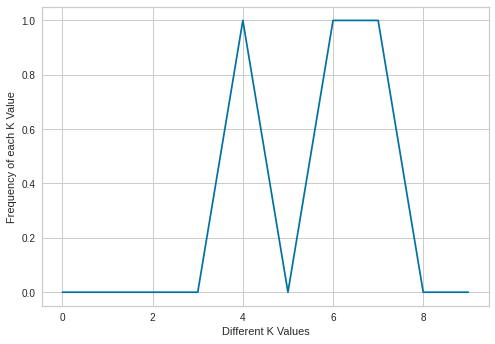

FOR ONE PER CLUSTER KNN


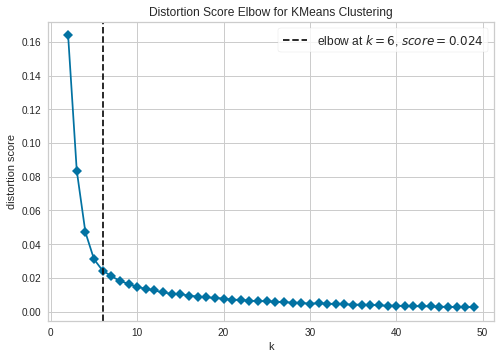

The corresponding accuracy is 0.8611111111111112
The corresponding mean k is 5


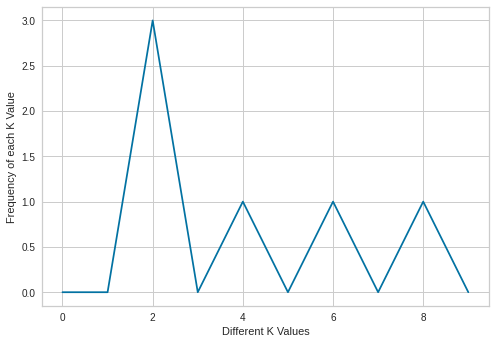



FOR SIMPLE KNN
The best K = 8 and the corresponding accuracy is 0.9473684210526315
FOR UNRESTRICTED KNN
Current Accuracy:  0.9298245614035088  for m = 2
The corresponding mean k is 3
Current Accuracy:  0.9385964912280702  for m = 3
The corresponding mean k is 4
Current Accuracy:  0.9385964912280702  for m = 4
The corresponding mean k is 5
Accuracy Score =  0.9385964912280702
The corresponding mean k is 4
Chosen m =  3


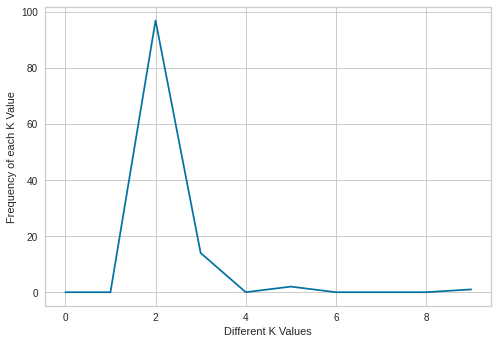

FOR PRUNNED KNN
Best Accuracy:  0.9385964912280702  for: 2


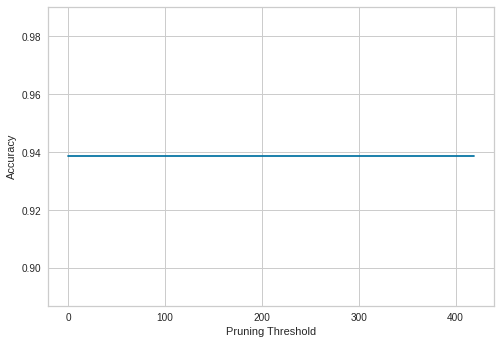

Accuracy Score =  0.9385964912280702
The corresponding mean k is 5
Chosen m =  3


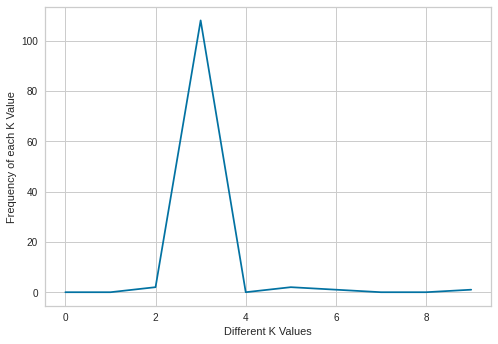

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.9385964912280702
The corresponding mean k is 5
The corresponding mean k is 5


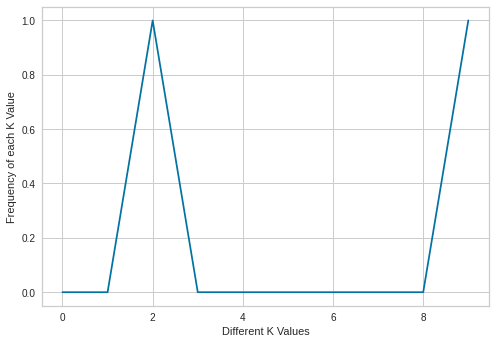

FOR ONE PER CLUSTER KNN


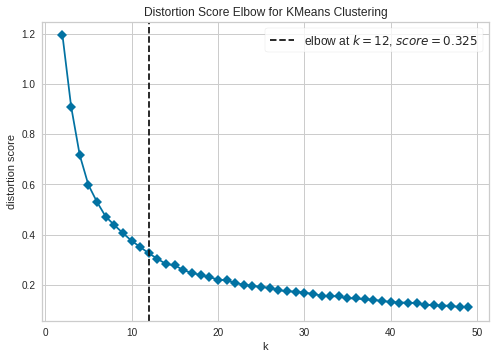

The corresponding accuracy is 0.9298245614035088
The corresponding mean k is 4


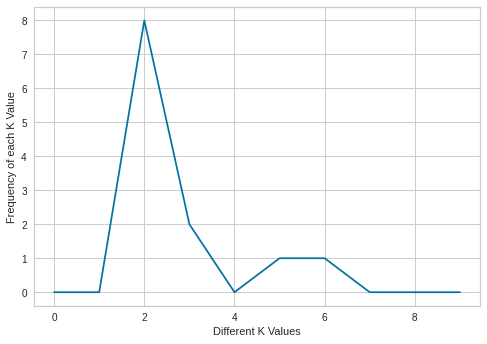

In [ ]:
def get_dataset(dataset):
  X = dataset.data
  y = dataset.target
  return X, y



# iris
X, y = get_dataset(datasets.load_iris())
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)

# wine
X, y = get_dataset(datasets.load_wine())
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)

# breast cancer
X, y = get_dataset(datasets.load_breast_cancer())
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)


FOR SIMPLE KNN
The best K = 3 and the corresponding accuracy is 0.9861111111111112
FOR UNRESTRICTED KNN
Current Accuracy:  0.9805555555555555  for m = 2
The corresponding mean k is 5
Current Accuracy:  0.9805555555555555  for m = 3
The corresponding mean k is 5
Current Accuracy:  0.9805555555555555  for m = 4
The corresponding mean k is 5
Accuracy Score =  0.9805555555555555
The corresponding mean k is 5
Chosen m =  2


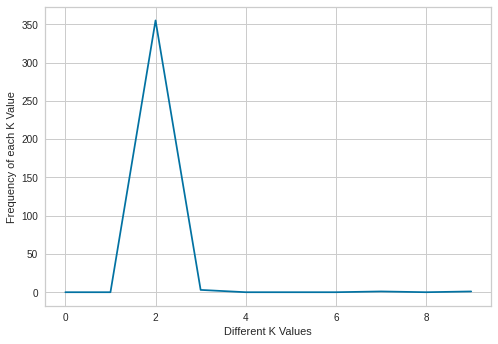

FOR PRUNNED KNN
Best Accuracy:  0.9805555555555555  for: 2


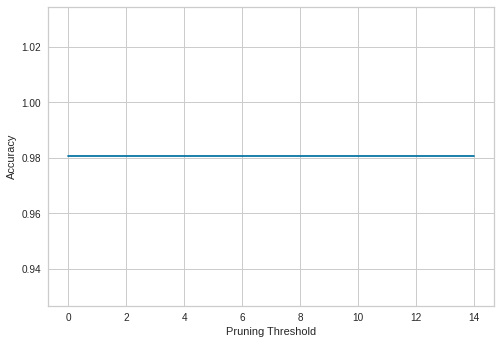

Accuracy Score =  0.9805555555555555
The corresponding mean k is 5
Chosen m =  2


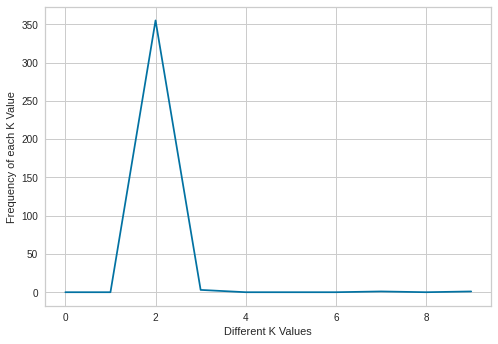

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.9833333333333333
The corresponding mean k is 5
The corresponding mean k is 5


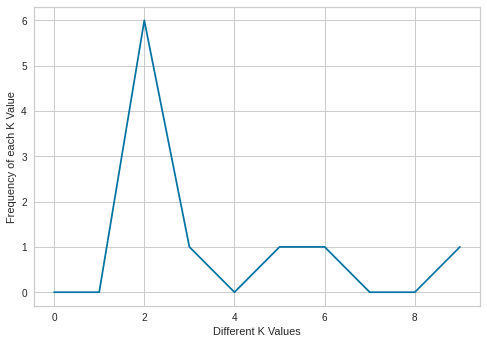

FOR ONE PER CLUSTER KNN


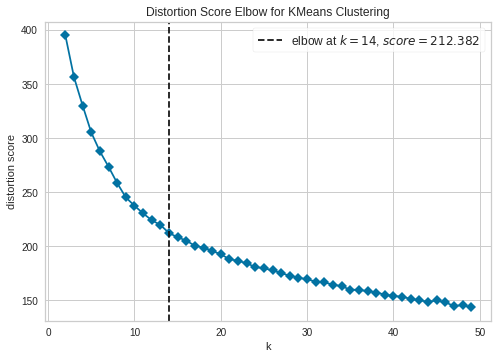

The corresponding accuracy is 0.9833333333333333
The corresponding mean k is 4


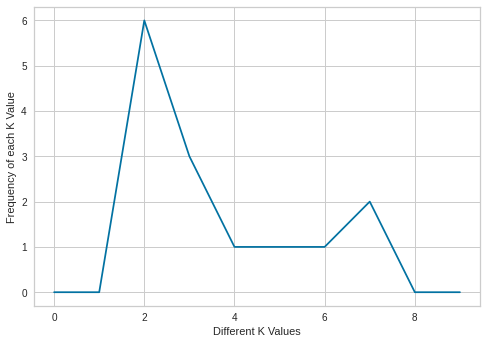

In [ ]:
# digit
X, y = get_dataset(datasets.load_digits())
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)


--2022-12-02 17:30:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.07s   

2022-12-02 17:30:43 (265 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]

     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0

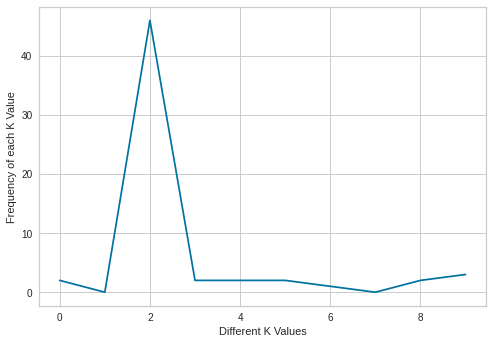

FOR PRUNNED KNN
Best Accuracy:  0.5833333333333334  for: 114


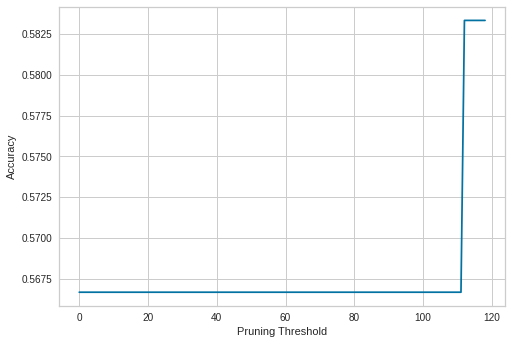

Accuracy Score =  0.5833333333333334
The corresponding mean k is 4
Chosen m =  4


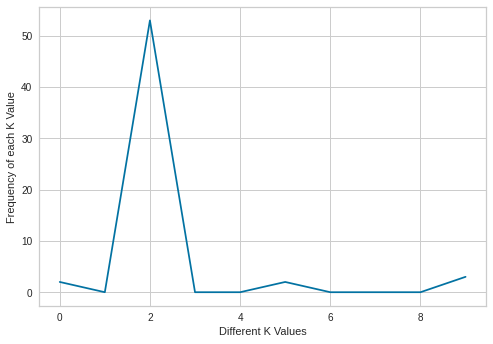

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.5333333333333333
The corresponding mean k is 5
The corresponding mean k is 5


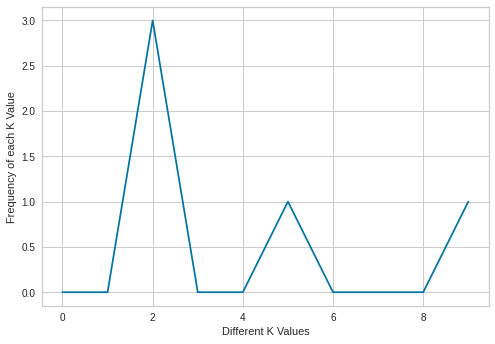

FOR ONE PER CLUSTER KNN


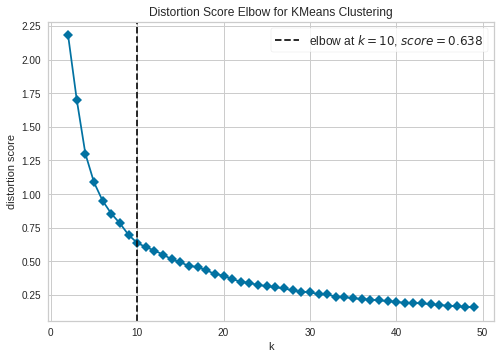

The corresponding accuracy is 0.5833333333333334
The corresponding mean k is 4


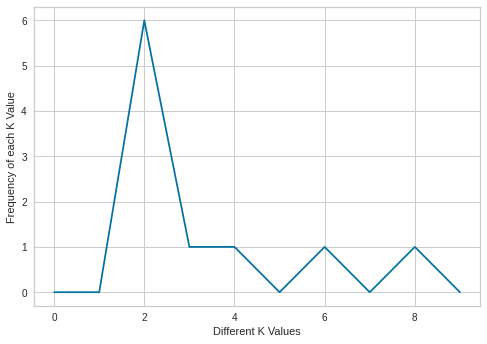

In [ ]:
#cleaved
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
  data = pd.read_csv(full_path, header=None)
  print(data.head())
  data.dropna()
  data = data[(data != '?').all(axis=1)]
	# retrieve numpy array
  data = data.values
	# split into input and output elements
  X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
  y = preprocessing.LabelEncoder().fit_transform(y)
  return X, y

X,y = load_dataset("processed.cleveland.data")
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)

--2022-12-02 17:32:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11903 (12K) [application/x-httpd-php]
Saving to: ‘glass.data’

glass.data          100%[===================>]  11.62K  --.-KB/s    in 0s      

2022-12-02 17:32:50 (109 MB/s) - ‘glass.data’ saved [11903/11903]

   0        1      2     3     4      5     6     7    8    9   10
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0   1
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0   1
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0   1
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0   1
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0   1
FOR SIMPLE KNN
The best K = 2 and the corresponding accuracy is 1.0
FOR 

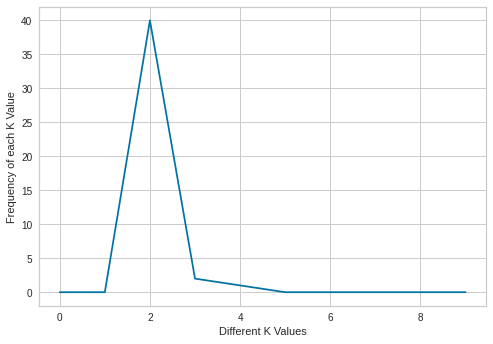

FOR PRUNNED KNN
Best Accuracy:  1.0  for: 2


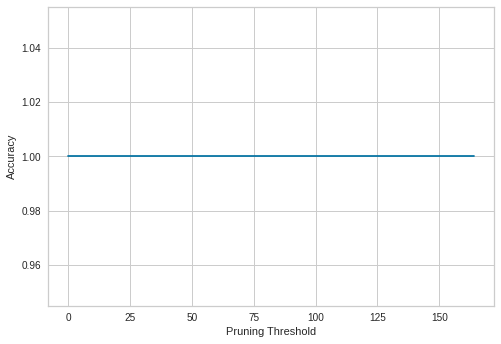

Accuracy Score =  1.0
The corresponding mean k is 3
Chosen m =  2


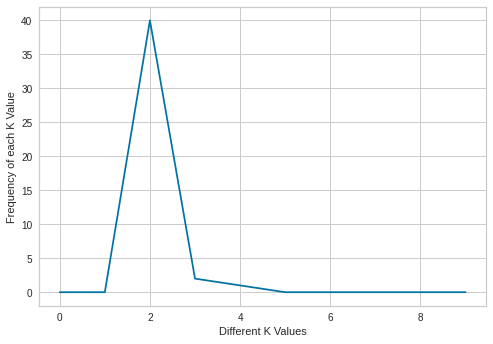

FOR ONE PER CLASS KNN
The corresponding accuracy is 1.0
The corresponding mean k is 4
The corresponding mean k is 4


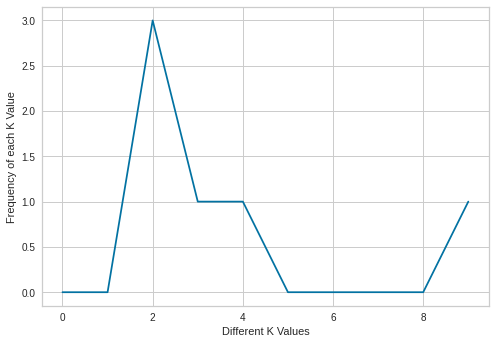

FOR ONE PER CLUSTER KNN


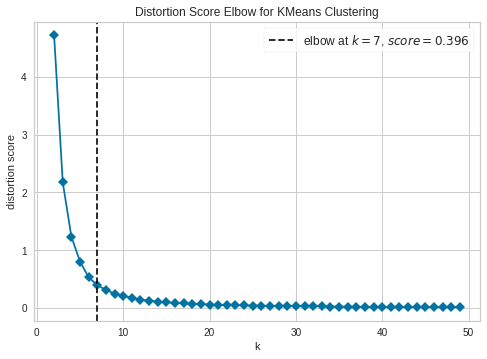

The corresponding accuracy is 1.0
The corresponding mean k is 3


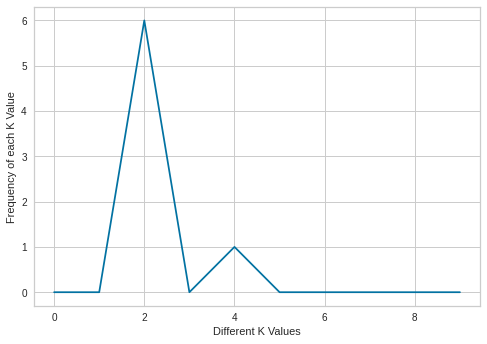

In [ ]:
#glass
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data
# glass
X,y = load_dataset("glass.data")
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)


--2022-12-02 17:34:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11058 (11K) [application/x-httpd-php]
Saving to: ‘reprocessed.hungarian.data.1’

reprocessed.hungari 100%[===================>]  10.80K  --.-KB/s    in 0s      

2022-12-02 17:34:14 (131 MB/s) - ‘reprocessed.hungarian.data.1’ saved [11058/11058]

                                        0
0   40 1 2 140 289 0 0 172 0 0 -9 -9 -9 0
1    49 0 3 160 180 0 0 156 0 1 2 -9 -9 1
2    37 1 2 130 283 0 1 98 0 0 -9 -9 -9 0
3  48 0 4 138 214 0 0 108 1 1.5 2 -9 -9 3
4    54 1 3 150 -9 0 0 122 0 0 -9 -9 -9 0
FOR SIMPLE KNN
The best K = 2 and the corresponding accuracy is 0.6440677966101694
FOR UNRESTRICTED KNN
Current Accuracy:  0.6271186440677966  for m = 2
The corre

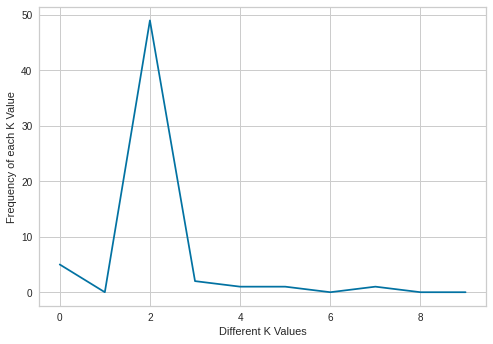

FOR PRUNNED KNN
Best Accuracy:  0.6271186440677966  for: 2


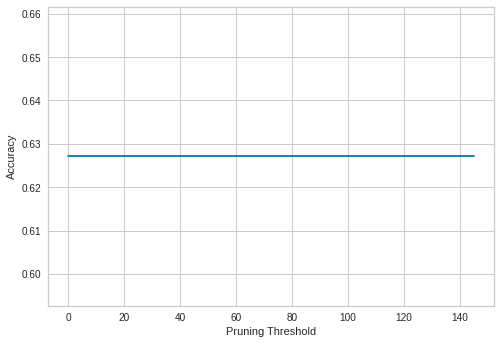

Accuracy Score =  0.6271186440677966
The corresponding mean k is 3
Chosen m =  2


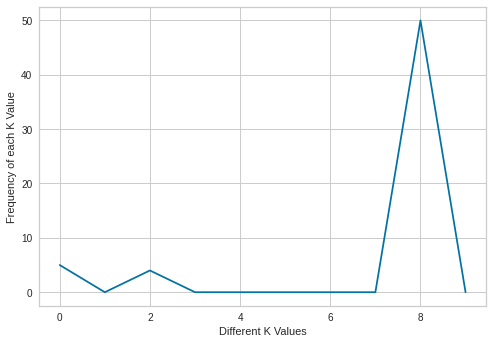

FOR ONE PER CLASS KNN
The corresponding accuracy is 0.6271186440677966
The corresponding mean k is 4
The corresponding mean k is 4


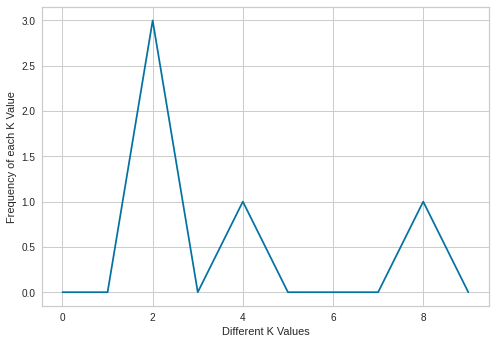

FOR ONE PER CLUSTER KNN


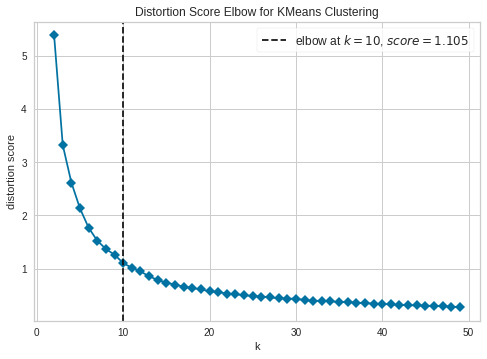

The corresponding accuracy is 0.6440677966101694
The corresponding mean k is 5


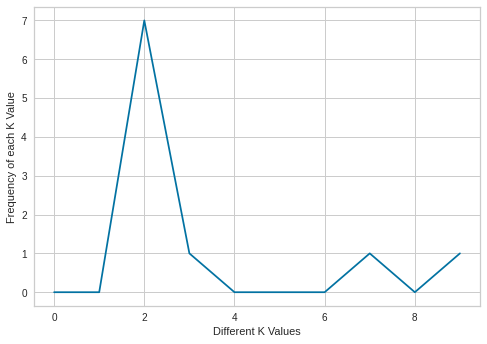

In [ ]:
#hungarian
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = pd.read_csv(full_path, header=None)
	# retrieve numpy array'
	print(data.head())
	#data = data[(data != '?').all(axis=1)]
	data = data.values
	data1 =[]
	for i in range(len(data)):
		data1.append(data[i][0].split(" "))
	data = np.array(data1)
		
	#print(data)
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = preprocessing.LabelEncoder().fit_transform(y)
	return X, y
X,y = load_dataset("reprocessed.hungarian.data")
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)
runAll(normalized_x_train, normalized_x_test, trainY, testY)

Text(0.5, 1.0, 'hungarian')

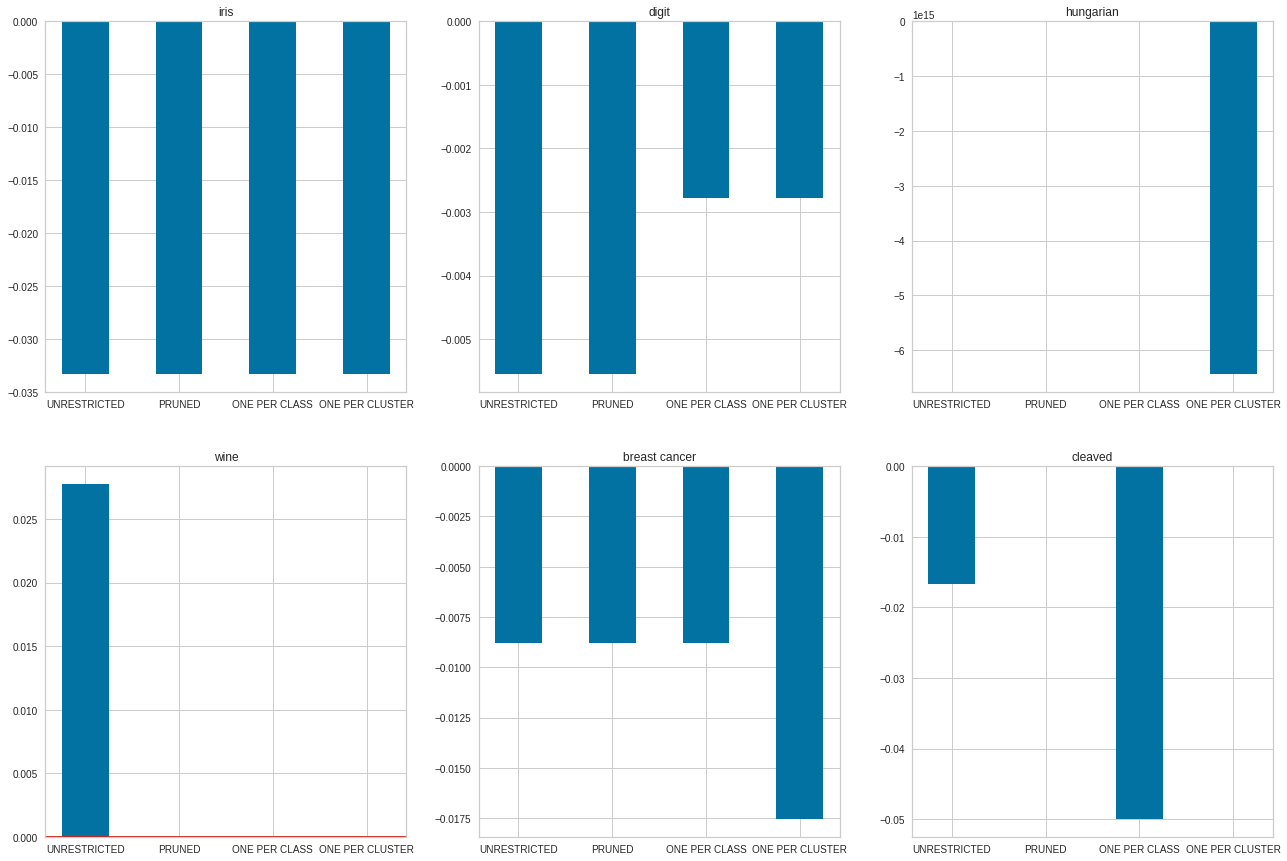

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(22, 15))
NAMES = ["UNRESTRICTED","PRUNED","ONE PER CLASS","ONE PER CLUSTER"]
iris = [0.9666666666666667-1, 0.9666666666666667-1, 0.9666666666666667-1, 0.9666666666666667-1]
axs[0][0].bar(NAMES, iris,width = 0.5)
axs[0][0].axhline(y=0, color='r', linestyle='-')
axs[0][0].set_title(f"iris")

digit = [0.9805555555555555- 0.9861111111111112, 0.9805555555555555-0.9861111111111112,0.9833333333333333- 0.9861111111111112,0.9833333333333333- 0.9861111111111112]
axs[0][1].bar(NAMES, digit,width = 0.5)
axs[0][1].axhline(y=0, color='r', linestyle='-')
axs[0][1].set_title(f"digit")

glass = []
#axs[0][2].bar(NAMES, iris)
#axs[0][2].set_title(f"glass")

wine = [0.8888888888888888 -0.8611111111111112, 0.8611111111111112- 0.8611111111111112,0.8611111111111112-0.8611111111111112,0.8611111111111112-0.8611111111111112]
axs[1][0].bar(NAMES, wine,width = 0.5)
axs[1][0].axhline(y=0, color='r', linestyle='-')
axs[1][0].set_title(f"wine")

breast = [0.9385964912280702-0.9473684210526315,0.9385964912280702-0.9473684210526315, 0.9385964912280702- 0.9473684210526315,0.9298245614035088-0.9473684210526315]
axs[1][1].bar(NAMES, breast,width = 0.5)
axs[1][1].axhline(y=0, color='r', linestyle='-')
axs[1][1].set_title(f"breast cancer")
cleaved = [ 0.5666666666666667-0.5833333333333334, 0.5833333333333334-0.5833333333333334 , 0.5333333333333333-0.5833333333333334, 0.5833333333333334-0.5833333333333334]
axs[1][2].bar(NAMES,cleaved,width = 0.5)
axs[1][2].axhline(y=0, color='r', linestyle='-')
axs[1][2].set_title(f"cleaved")
hungarian = [0.6271186440677966-0.6440677966101694,0.6271186440677966-0.6440677966101694,0.6271186440677966-0.64406779661016940,0.6440677966101694-6440677966101694]
axs[0][2].bar(NAMES, hungarian,width = 0.5)
axs[0][2].axhline(y=0, color='r', linestyle='-')
axs[0][2].set_title(f"hungarian")

Text(0.5, 1.0, 'hungarian')

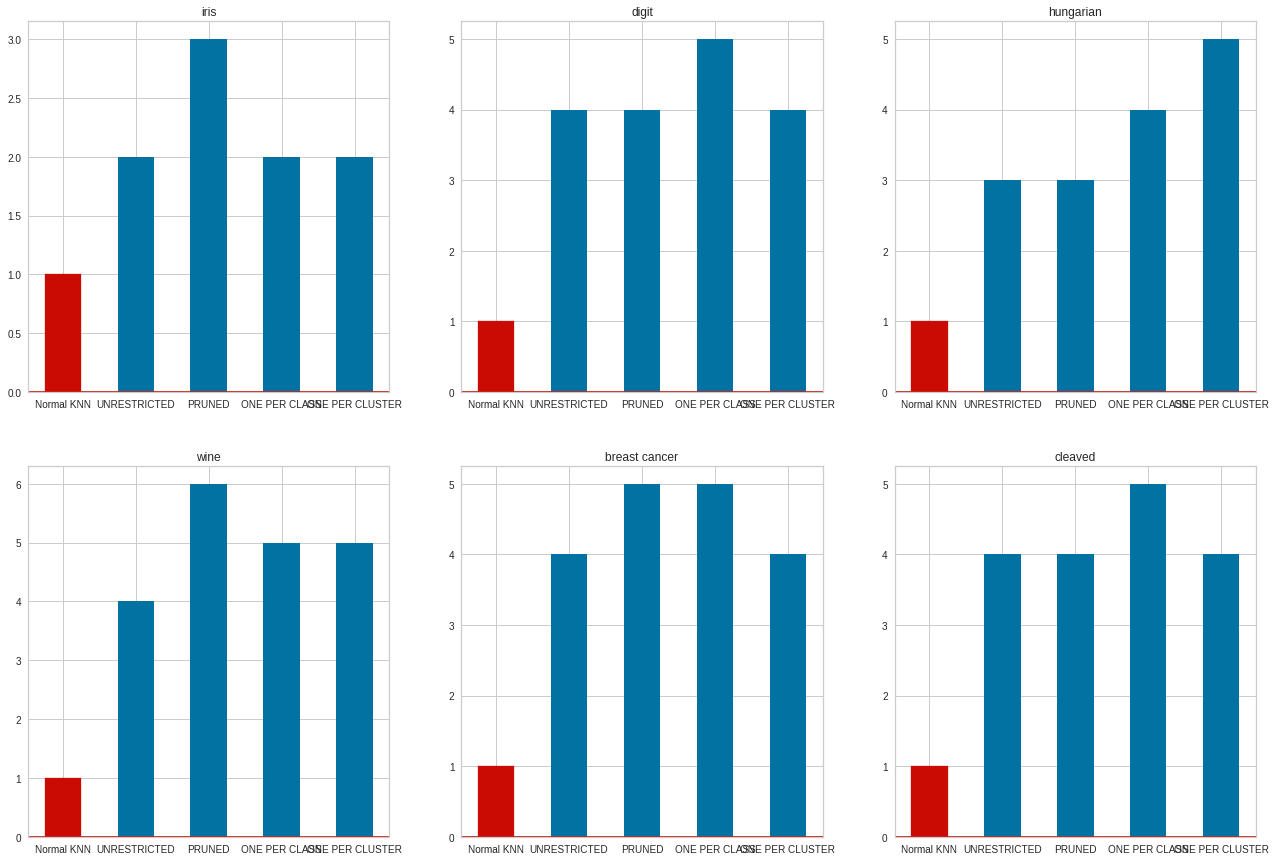

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(22, 15))
NAMES = ["Normal KNN","UNRESTRICTED","PRUNED","ONE PER CLASS","ONE PER CLUSTER"]
iris = [1,2, 3, 2, 2]
bars = axs[0][0].bar(NAMES, iris,width = 0.5)
bars[0].set_color('r')
axs[0][0].axhline(y=0, color='r', linestyle='-')
axs[0][0].set_title(f"iris")

digit = [1,4, 4,5,4]
bars = axs[0][1].bar(NAMES, digit,width = 0.5)
bars[0].set_color('r')
axs[0][1].axhline(y=0, color='r', linestyle='-')
axs[0][1].set_title(f"digit")

glass = []
#axs[0][2].bar(NAMES, iris)
#axs[0][2].set_title(f"glass")

wine = [1,4,6,5,5]
bars = axs[1][0].bar(NAMES, wine,width = 0.5)
bars[0].set_color('r')

axs[1][0].axhline(y=0, color='r', linestyle='-')
axs[1][0].set_title(f"wine")

breast = [1,4,5, 5,4]
bars = axs[1][1].bar(NAMES, breast,width = 0.5)
bars[0].set_color('r')
axs[1][1].axhline(y=0, color='r', linestyle='-')
axs[1][1].set_title(f"breast cancer")
cleaved = [ 1,4, 4 , 5, 4]
bars = axs[1][2].bar(NAMES,cleaved,width = 0.5)
axs[1][2].axhline(y=0, color='r', linestyle='-')
bars[0].set_color('r')
axs[1][2].set_title(f"cleaved")
hungarian = [1,3,3,4,5]
bars = axs[0][2].bar(NAMES, hungarian,width = 0.5)
bars[0].set_color('r')
axs[0][2].axhline(y=0, color='r', linestyle='-')
axs[0][2].set_title(f"hungarian")

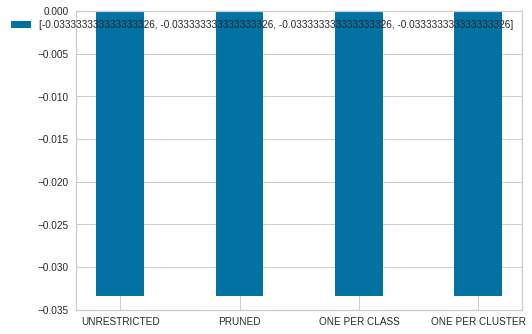

In [ ]:
plt.bar(NAMES, iris,width = 0.4,label = iris)
plt.legend()

<BarContainer object of 4 artists>

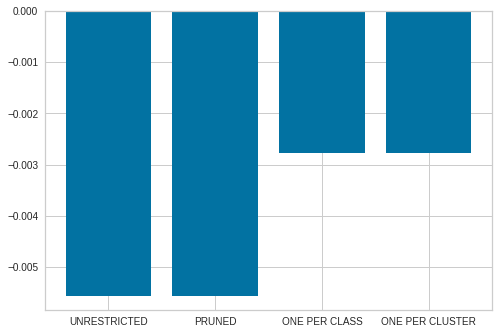

In [ ]:
plt.bar(NAMES, digit)

<BarContainer object of 4 artists>

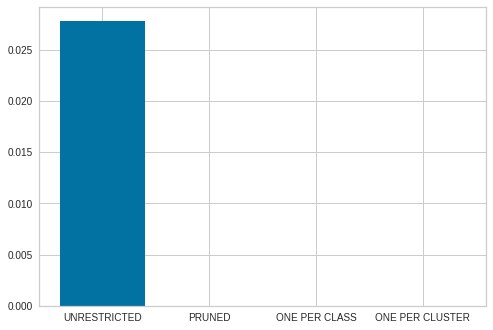

In [ ]:
plt.bar(NAMES, wine)

<BarContainer object of 4 artists>

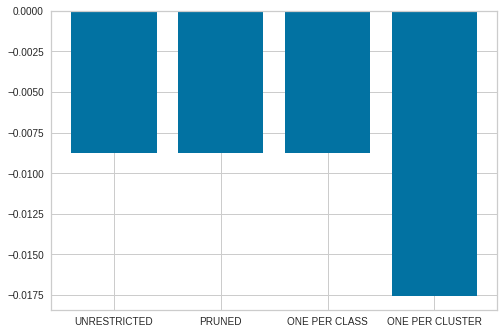

In [ ]:
plt.bar(NAMES, breast )

<BarContainer object of 4 artists>

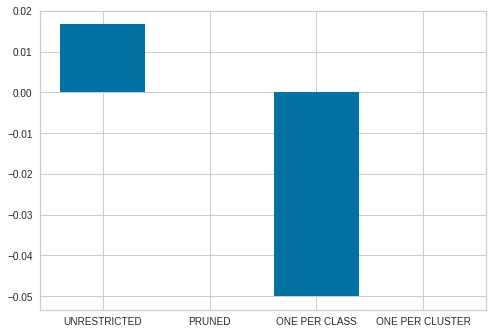

In [ ]:
plt.bar(NAMES,cleaved)

<BarContainer object of 4 artists>

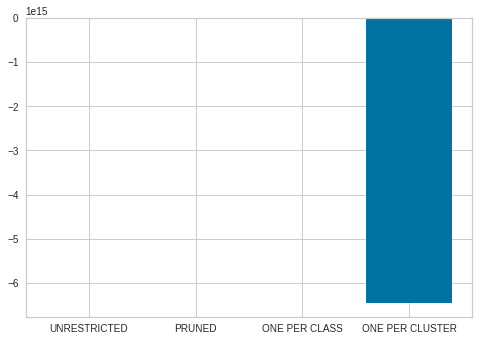

In [ ]:
plt.bar(NAMES, hungarian)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15), sharey=True)
NAMES = ["UNRESTRICTED","PRUNED","ONE PER CLASS","ONE PER CLUSTER"]
iris = [0.96-5, 0.9666666666666667-5, 0.9666666666666667-5, 0.9666666666666667-5]
axs[0][0].bar(NAMES, iris)
axs[0][0].set_title(f"iris")

digit = [0.9805555555555555- 0.9861111111111112, 0.9805555555555555-0.9861111111111112,0.9833333333333333- 0.9861111111111112,0.9833333333333333- 0.9861111111111112]
axs[0][1].bar(NAMES, digit)
axs[0][1].set_title(f"digit")

glass = []
#axs[0][2].bar(NAMES, iris)
#axs[0][2].set_title(f"glass")

wine = [0.8888888888888888 -0.8611111111111112, 0.8611111111111112- 0.8611111111111112,0.8611111111111112-0.8611111111111112,0.8611111111111112-0.8611111111111112]
axs[1][0].bar(NAMES, wine)
axs[1][0].set_title(f"wine")

breast = [0.9385964912280702-0.9473684210526315,0.9385964912280702-0.9473684210526315, 0.9385964912280702- 0.9473684210526315,0.9298245614035088-0.9473684210526315]
axs[1][1].bar(NAMES, breast )
axs[1][1].set_title(f"breast cancer")
cleaved = [ 0.5833333333333334-0.5666666666666667, 0.5833333333333334-0.5833333333333334 , 0.5333333333333333-0.5833333333333334, 0.5833333333333334-0.5833333333333334]
axs[1][2].bar(NAMES,cleaved)
axs[1][2].set_title(f"cleaved")
hungarian = [0.6271186440677966-0.6440677966101694,0.6271186440677966-0.6440677966101694,0.6271186440677966-0.64406779661016940,0.6440677966101694-6440677966101694]
axs[0][2].bar(NAMES, hungarian)
axs[0][2].set_title(f"hungarian")